In [1]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import arviz as az

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

from datetime import date
import os

from tqdm import tqdm

In [5]:
import importlib
import simulate_data
importlib.reload(simulate_data)

true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

import model_metropolis_hastings
importlib.reload(model_metropolis_hastings)

from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import poisson


sir_model = model_metropolis_hastings.SIR_model(data)

prior = {
    'rt_0':{
        'dist': uniform,
        'args':{
        'lower': 1.,
        'upper': 4.,
        }
    },
    'rt_1':{
        'dist': uniform,
        'args': {
            'lower': 1.5,
            'upper': 4.,
        }
    },
    'k':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['k'],
        # }
        'dist': uniform,
        'args': {
            'lower': 0.01,
            'upper': 2,
        }
    },
    'midpoint':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['midpoint'],
        # }
        'dist': randint,
        'args': {
            'lower': 30,
            'upper': 200,
        }
    },
    'I0':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['I0'],
        # }
        'dist': poisson,
        'args': {
            'mu': 50,
        }
    },
}

n_samples = 500
n_tune = 100
tune_interval = 100

today = date.today() 
name = f"custom_MH_likelihood_normal"
path = os.path.abspath(f'../data/{today}_{name}')

sir_model.run_SIR_model(n_samples, n_tune, tune_interval, prior, path)

100%|███████████████████████████████████████████████████| 600/600 [00:58<00:00, 10.34it/s]


               mean     HDI 3%     HDI 94%  truth
rt_0       1.550729   1.096211    1.819778    1.4
k          0.314693   0.083015    0.565674    0.1
rt_1       2.975735   1.904725    3.802795    3.0
I0         7.598802   0.000000   28.000000  100.0
midpoint  95.137725  74.000000  117.000000  100.0
[0.18833333 0.20333333 0.19333333 0.19166667 0.19166667]


### Grid Search

In [11]:
rt_0s = np.arange(1.,2.,0.1)
rt_1s = np.arange(1.5,4.,0.1)
midpoints = np.arange(75,125,5)

chain = []
likelihood_list = []
likelihood_arr = np.zeros((len(rt_1s),len(rt_0s), len(midpoints)))
prior_list = []

for ia, a in tqdm(enumerate(rt_0s)):
    for ib, b in enumerate(rt_1s):
        for im, m in enumerate(midpoints):
            params_t = {
                'rt_0':a,
                'rt_1':b,
                'k': true_params['k'],
                'midpoint': m,
                'I0': true_params['I0'],
            }
            chain.append(params_t.copy())

            _, _, _, i = sir_model.integrate(
                            t_I=true_params['t_I'], N=true_params['N'], S0=true_params['N']- true_params['I0'],
                            n_t=true_params['n_t'], **params_t.copy())

            logprior = sir_model.logprior_prob(prior, **params_t)
            loglike = sir_model.loglike_prob(i)

            prior_list.append(logprior)
            likelihood_list.append(loglike)
            likelihood_arr[ib][ia][im] = loglike


10it [00:35,  3.53s/it]


In [12]:
df1 = pd.DataFrame(chain)
df2 = pd.DataFrame(data=np.vstack([likelihood_list, prior_list]).T, columns=['log_likelihood', 'log_prior'])

df = pd.concat([df1, df2], axis=1)

df.head()

,rt_0,rt_1,k,midpoint,I0,log_likelihood,log_prior
0,1.0,1.5,0.1,75,100.0,-5.183774e+05,-30.381776
1,1.0,1.5,0.1,80,100.0,-3.583660e+05,-30.381776
2,1.0,1.5,0.1,85,100.0,-3.065054e+05,-30.381776
3,1.0,1.5,0.1,90,100.0,-1.459037e+06,-30.381776
4,1.0,1.5,0.1,95,100.0,-2.329789e+06,-30.381776


In [47]:
np.where((rt_0s < 1.41) & (rt_0s > 1.39))

(array([4]),)

In [48]:
np.where((rt_1s < 3.1) & (rt_1s > 3.0))

(array([15]),)

In [49]:
np.where((midpoints == 100))

(array([5]),)

In [53]:
midpoints[5]

100

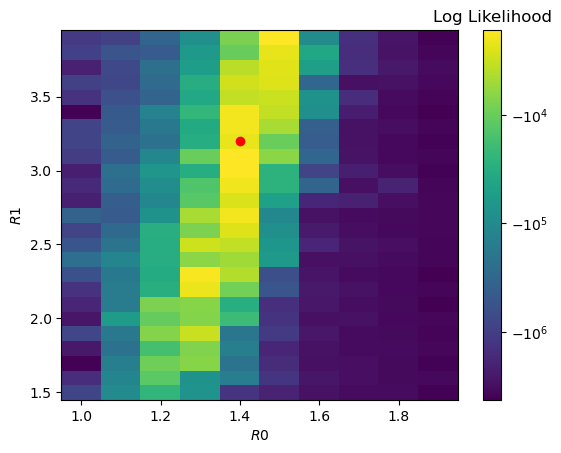

In [54]:
from matplotlib.colors import SymLogNorm

rt_1_ix, rt_0_ix, midpoint_ix = np.unravel_index(np.argmax(likelihood_arr), likelihood_arr.shape)

plt.pcolor(rt_0s, rt_1s, likelihood_arr[:,:,5], norm=SymLogNorm(0.5))
plt.xlabel(r'$R0$')
plt.ylabel(r'$R1$')
clb = plt.colorbar()
clb.ax.set_title('Log Likelihood')
plt.plot(rt_0s[rt_0_ix], rt_1s[rt_1_ix], 'or', label='maximum likelihood')


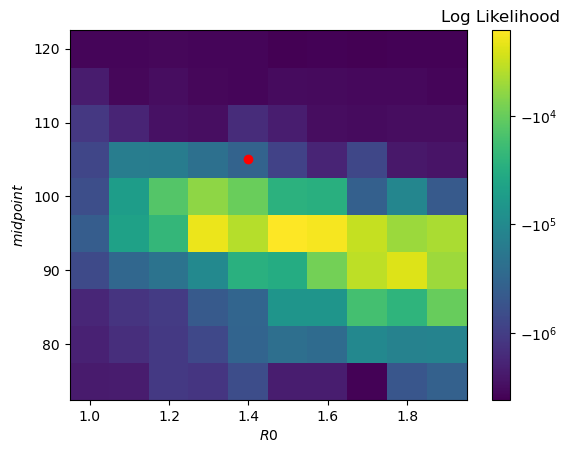

In [56]:
plt.pcolor(rt_0s, midpoints, likelihood_arr[15,:,:], norm=SymLogNorm(0.5))
plt.xlabel(r'$R0$')
plt.ylabel(r'$midpoint$')
clb = plt.colorbar()
clb.ax.set_title('Log Likelihood')
plt.plot(rt_0s[rt_0_ix], midpoints[midpoint_ix], 'or', label='maximum likelihood')

In [57]:
rt_0s[rt_0_ix], rt_1s[rt_1_ix], midpoints[midpoint_ix]

(1.4000000000000004, 3.2000000000000015, 105)